In [1]:
# Install HermesPy and its dependencies in the current kernel
# When running on Colabs, a restart of the runtime is required afterwards

import sys
!{sys.executable} -m pip install --quiet hermespy

Receiver Operating Characteristics
==================================

This tutorial will outline how to operate Hermes' API in order to estimate receiver operating characteristics of sensing detectors within Monte Carlo simulations and using software defined radios.

Let's start by configuring a simulated scenario consisting of a single device transmitting an [FMCW](../api/radar.fmcw.rst#hermespy.radar.fmcw.FMCW) waveform at a carrier frequency of $10~\mathrm{GHz}$.
The transmitted chirps sweep a bandwidth of $3.072~\mathrm{Ghz}$ during $20~\mathrm{ms}$, with each frame consisting of $10$ identical chirps.

In [2]:
from hermespy.core import ConsoleMode
from hermespy.simulation import Simulation
from hermespy.radar import Radar, FMCW, ReceiverOperatingCharacteristic

# Global parameters
bandwidth = 3.072e9
carrier_frequency = 10e9
chirp_duration = 2e-8
num_chirps = 10
pulse_rep_interval = 1.1 * chirp_duration

# New radar waveform
radar = Radar()
radar.waveform = FMCW(bandwidth=bandwidth, num_chirps=num_chirps, chirp_duration=chirp_duration, pulse_rep_interval=pulse_rep_interval)

# Simulation with a single device
simulation = Simulation(console_mode=ConsoleMode.SILENT)
simulated_device = simulation.new_device(carrier_frequency=carrier_frequency)
radar.device = simulated_device

We can inspect the [Radar's](../api/radar.radar.Radar.rst#hermespy.radar.radar.Radar) transmitted waveform by plotting a single chirp and the full frame:

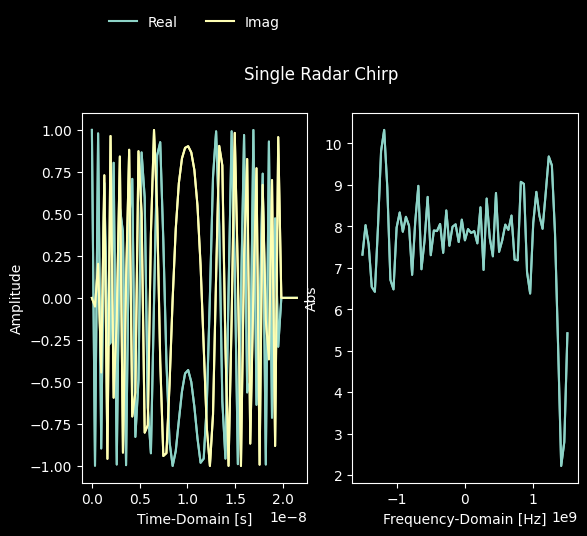

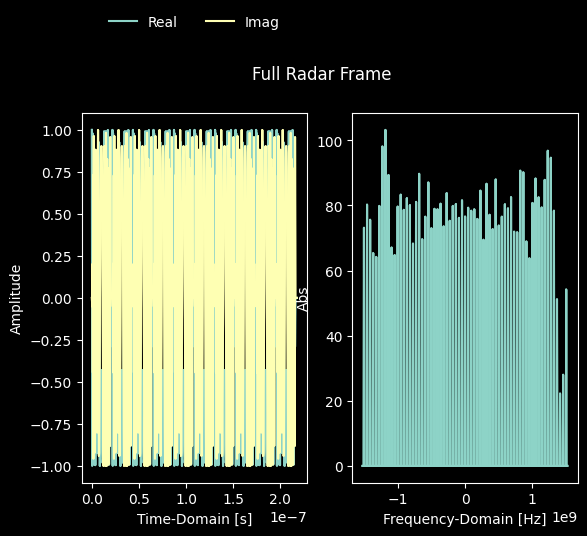

In [3]:
import matplotlib.pyplot as plt

radar.waveform.num_chirps = 1
_ = radar.transmit().signal.plot(title='Single Radar Chirp')

radar.waveform.num_chirps = num_chirps
_ = radar.transmit().signal.plot(title='Full Radar Frame')

plt.show()

Typical hardware impairments limiting the performance of monostatic radars are isolation between transmitting and receiving RF chains and the base hardware noise.

Lets assume a scattering target located at a distance $0.75~\mathrm{m}$ and $1.25~\mathrm{m}$ from the radar with a cross section of $1~\mathrm{m}^2$, which is roughly the expected radar cross section of a human.
The hardware should have an absolute noise floor between $10~\mathrm{dB}$ and $20~\mathrm{dB}$ and a [power leakage](../api/simulation.isolation.specific.rst#hermespy.simulation.isolation.specific.SpecificIsolation) from transmit to receive antenna between with an isolation $30~\mathrm{dB}$ and $10~\mathrm{dB}$.
Additionally, we'll consider an [analog to digital conversion](../api/simulation.rf_chain.adc.rst) with $8~\mathrm{Bit}$ quantization and [automatic gain control](../api/simulation.rf_chain.adc.AutomaticGainControl.rst#hermespy.simulation.rf_chain.analog_digital_converter.AutomaticGainControl) at the receiver.

The following lines configure our system assumptions and run a simulation estimating the expected operating characteristcs:

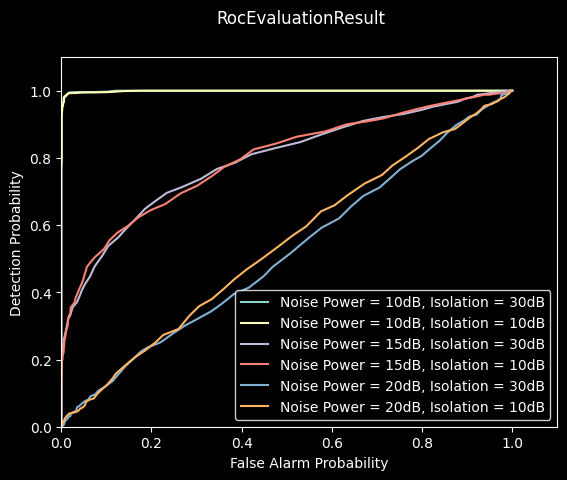

In [4]:
from hermespy.core import ConsoleMode, dB
from hermespy.channel import SingleTargetRadarChannel
from hermespy.simulation import AutomaticGainControl, N0, SpecificIsolation

# Initialize a new simulation scenario
simulation = Simulation(console_mode=ConsoleMode.SILENT)
simulated_device = simulation.new_device(carrier_frequency=carrier_frequency)
radar.device = simulated_device

# Configure a radar channel
radar_channel = SingleTargetRadarChannel(target_range=(.75, 1.25), radar_cross_section=1., attenuate=False)
simulation.scenario.set_channel(simulated_device, simulated_device, radar_channel)

# Configure a leakage between transmit and receive RF chains
simulated_device.noise_level = N0(1.0)
simulated_device.isolation = SpecificIsolation(isolation=dB(30.))
simulated_device.rf_chain.adc.gain = AutomaticGainControl()
simulated_device.rf_chain.adc.num_quantization_bits = 8

# Configure a simulation sweep over multiple snr and isolation candidates
simulation.new_dimension('noise_level', dB(10., 15., 20.), simulated_device)
simulation.new_dimension('isolation', dB(30., 10.), simulation.scenario.devices[0].isolation)
simulation.num_drops = 1000

# Evaluate the radar's operator characteristics
roc = ReceiverOperatingCharacteristic(radar, radar_channel)
simulation.add_evaluator(roc)

# Run the simulation campaign
result = simulation.run()

# Visualize the ROC
_ = result.plot()
plt.show()

All parameter combinations perform reasonably well.
Notably, at the most favorable parameter combination (a low noise floor of $10~\mathrm{dB}$ and a high isolation of $30~\mathrm{dB}$), the radar is an almost perfect detector.

Receiver operating characteristics may not only be predicted by means of simulation but can also be estimated from real-world measurements of hardware testbeds operated by Hermes.

Let's mock a measurement configuration with identical parameters to the Monte Carlo simulation:

In [5]:
from hermespy.hardware_loop import HardwareLoop, SimulatedPhysicalScenario


# Set up a simulated physical scenario
system = SimulatedPhysicalScenario()
system.noise_level = N0(dB(15))

# Configure a hardware loop collect measurments from the physical scenario
hardware_loop = HardwareLoop(system, console_mode=ConsoleMode.SILENT)
hardware_loop.plot_information = False
hardware_loop.num_drops = 1000
hardware_loop.results_dir = hardware_loop.default_results_dir()

# Add a new device to the simulated physical scenario
simulated_device = system.new_device(carrier_frequency=carrier_frequency)
radar.device = simulated_device

simulated_device.isolation = SpecificIsolation(isolation=dB(30.))
simulated_device.rf_chain.adc.gain = AutomaticGainControl()
simulated_device.rf_chain.adc.num_quantization_bits = 8

# Configure an identical radar channel
radar_channel = SingleTargetRadarChannel(target_range=(.75, 1.25), radar_cross_section=1., attenuate=False)
system.set_channel(simulated_device, simulated_device, radar_channel)

Now, we may run two measurement campaigns, collecting measurment data with the radar target present and the radar target missing from the signal impinging onto the device after channel propagation:

In [6]:
# First measurement campaign with the target in front of the device
radar_channel.target_exists = True
hardware_loop.run(overwrite=False, campaign='h1_measurements')

# Second measurement campaign with the target removed
radar_channel.target_exists = False
hardware_loop.run(overwrite=False, campaign='h0_measurements')

The measurement data and all device parameterizations will be saved to a binary file on the user's drive.
The data can be inspected offline, and information such as the operating charactersitics may be computed by a single command:

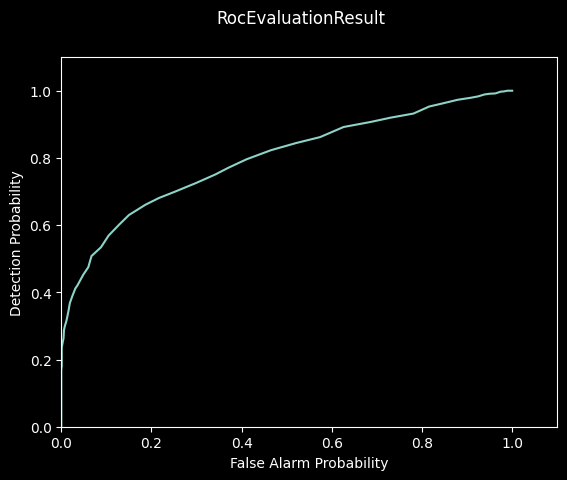

In [7]:
from os import path


# Compute the ROC from a measurment dataset
roc = ReceiverOperatingCharacteristic.From_HDF(path.join(hardware_loop.results_dir, 'drops.h5'))

# Visualize the result
roc.visualize()
plt.show()